In [8]:
import os
import re
import datetime
import tempfile

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 250)
# Don't cut off long string
# http://stackoverflow.com/questions/26277757/pandas-to-html-truncates-string-contents
pd.set_option('display.max_colwidth', -1)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 9)

from misc import utils

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print(datetime.datetime.now().date())

2016-09-21


In [5]:
df = pd.read_csv('data/LATEST_MANIFEST.final.tsv.gz', low_memory=False, sep='\t', compression='gzip')

In [6]:
# only interested in those with state equals Live
ndf = df[(df.study == 'TCGA') & (df.library_type == 'RNA-Seq') & (df.state == 'Live') & (df.file_type != 'bam')]

In [17]:
ndf = ndf.copy()

#### Centers

In [18]:
ndf.center.value_counts()

UNC-LCCC    9943
BCCAGSC     1260
BI          171 
Name: center, dtype: int64

##### Library types

In [19]:
ndf.library_type.value_counts()

RNA-Seq    11374
Name: library_type, dtype: int64

##### File types

In [20]:
ndf.file_type.value_counts()

fasta    11374
Name: file_type, dtype: int64

#### Diesase types

In [22]:
ndf['handy_disease_names'] = ndf.apply(lambda x: '{0}: {1}'.format(
        x.disease, ' '.join([_.capitalize() for _ in x.disease_name.split()])), axis=1)
ndf.handy_disease_names.value_counts()

BRCA: Breast Invasive Carcinoma                                           1256
KIRC: Kidney Renal Clear Cell Carcinoma                                   618 
LUAD: Lung Adenocarcinoma                                                 601 
UCEC: Uterine Corpus Endometrioid Carcinoma                               593 
THCA: Thyroid Carcinoma                                                   572 
HNSC: Head And Neck Squamous Cell Carcinoma                               566 
PRAD: Prostate Adenocarcinoma                                             558 
LUSC: Lung Squamous Cell Carcinoma                                        555 
COAD: Colon Adenocarcinoma                                                546 
LGG: Brain Lower Grade Glioma                                             534 
SKCM: Skin Cutaneous Melanoma                                             473 
STAD: Stomach Adenocarcinoma                                              453 
BLCA: Bladder Urothelial Carcinoma                  

#### Number of samples

In [23]:
ndf.shape[0]

11374

##### File sizes

In [24]:
# Note: the count doesn't make sense when converting to filesize, so it's shown separately
from misc.utils import sizeof_fmt
# args: pass a sep character for better readbility. See sizeof_fmt?? for more details
ndf.files_size.describe().apply(sizeof_fmt, args=(' ',))

count    11.1KB 
mean     6.2GB  
std      3.0GB  
min      278.3MB
25%      4.6GB  
50%      5.7GB  
75%      6.9GB  
max      27.7GB 
Name: files_size, dtype: object

#### Would be interesting to find out what the smallest and biggest files are

In [25]:
cols_to_show = ['disease_name', 'sample_type_name', 'filename', 'file_type',
                'files_size', 'files_size_readable', 'library_type', 'state']
# turn off warning, http://stackoverflow.com/questions/20625582/how-to-deal-with-this-pandas-warning
ndf.is_copy = False
ndf['files_size_readable'] = ndf.files_size.apply(sizeof_fmt)
sorted_ndf = ndf.sort_values('files_size').reset_index()
sorted_ndf.ix[[0,sorted_ndf.shape[0]-1]][cols_to_show]

,disease_name,sample_type_name,filename,file_type,files_size,files_size_readable,library_type,state
0,COLON ADENOCARCINOMA,Primary solid Tumor,UNCID_2206900.559bc3f5-8d24-4740-942f-a2504739c917.110817_UNC6-RDR300211_00122_FC_6315AAXX_6.tar.gz,fasta,2.918121e+08,278.3MB,RNA-Seq,Live
11373,OVARIAN SEROUS CYSTADENOCARCINOMA,Primary solid Tumor,TCGA-29-1699-01A-01R-1567-13_rnaseq_fastq.tar,fasta,2.972934e+10,27.7GB,RNA-Seq,Live


#### File sizes distribution

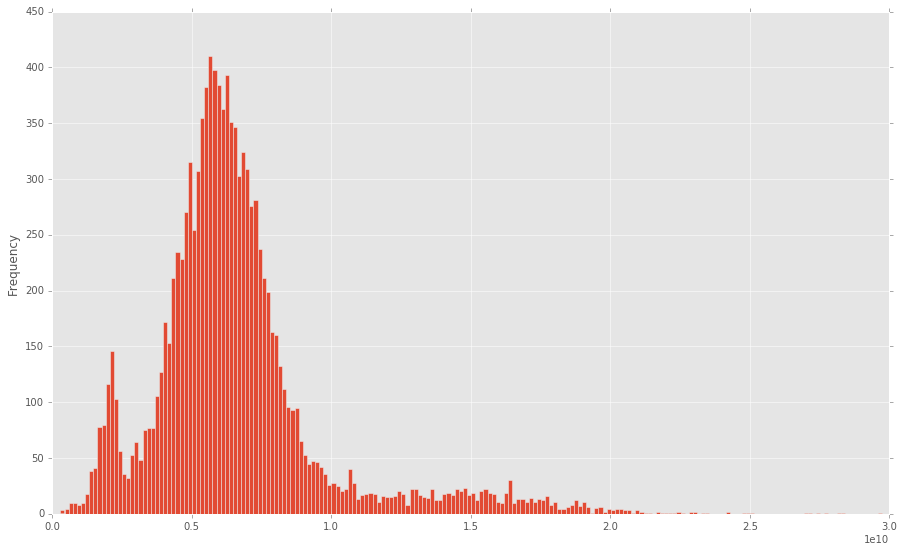

In [28]:
ndf.files_size.plot(kind='hist', bins=200)

In [30]:
sizeof_fmt(2e10)

'18.6GB'

In [31]:
'{0:.2%}'.format(ndf[ndf.files_size > 2e10].shape[0] / float(ndf.shape[0]))

'0.46%'

So only 0.81% of the files are above 18.6 GB, and the majority are below.

#### Look at a particular normal vs tumor pair

In [32]:
ndf[(ndf.aliquot_id == '469f052a-477e-498a-ba3b-f288dcbc306f') | (ndf.aliquot_id == '19c97e3d-f5af-4301-92f4-be8ac9e27427')]

,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,handy_disease_names,files_size_readable
7188,TCGA,TCGA-BC-A10Q-11A-11R-A131-07,LIHC,LIVER HEPATOCELLULAR CARCINOMA,NT,Solid Tissue Normal,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2207989.469f052a-477e-498a-ba3b-f288dcbc306f.110629_UNC14-SN744_0136_AD0CV5ABXX_3_ACTTGA.tar.gz,5.833322e+09,ed9eb3a96c2b37aabc75df35aef38196,66b0260b-f242-4eea-9c9f-a96e1ec7f0f9,469f052a-477e-498a-ba3b-f288dcbc306f,dfa15fbe-bb14-40ce-afc6-70694112e3e2,5d3bf988-3331-4412-bc17-b8f4650a8623,BC,NaN,2013-09-30,2013-09-30,2013-09-30,Live,11,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIHC: Liver Hepatocellular Carcinoma,5.4GB
7189,TCGA,TCGA-BC-A10Q-01A-11R-A131-07,LIHC,LIVER HEPATOCELLULAR CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2207997.19c97e3d-f5af-4301-92f4-be8ac9e27427.110629_UNC14-SN744_0136_AD0CV5ABXX_2_TTAGGC.tar.gz,5.242180e+09,98232bfea569de53517aa9d06f2f2781,1e2cc863-1123-451c-a295-0323fb421188,19c97e3d-f5af-4301-92f4-be8ac9e27427,dfa15fbe-bb14-40ce-afc6-70694112e3e2,bf225dc1-4309-4304-849e-cbcc23c8442c,BC,NaN,2013-09-30,2013-09-30,2013-09-30,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIHC: Liver Hepatocellular Carcinoma,4.9GB


In [33]:
ndf.sample_type_name.value_counts()

Primary solid Tumor                                9996
Solid Tissue Normal                                742 
Metastatic                                         394 
Primary Blood Derived Cancer - Peripheral Blood    179 
Recurrent Solid Tumor                              50  
Additional - New Primary                           11  
Control Analyte                                    1   
Additional Metastatic                              1   
Name: sample_type_name, dtype: int64